# Examples of utils provided by ReGraph's Neo4jHierarchy module

In [1]:
import networkx as nx
from regraph import Rule, plot_rule


from regraph.neo4j.hierarchy import Neo4jHierarchy
import regraph.neo4j.cypher_utils as cypher

## Initializing Neo4j database

0. When installing neo4j you will be asked to choose login/password for you dbs (here its "neo4j"/"admin"), if you choose other -- change in the cell below.
1. To start neo4j server run `sudo service neo4j start`
2. Check status by running `sudo service neo4j status`. Here you can check the _bolt_ port, change the cell below if different from 7687
3. You can query the db by using the neo4j browser, the address can be found also in the result of 'status', e.g. "Remote interface available at http://localhost:7474/".

In [2]:
# initialize the neo4j driver, wrappped into Neo4jHierarchy object
h = Neo4jHierarchy(uri="bolt://localhost:7687", user="neo4j", password="admin")
h._clear()

## Hierarchy

A hierarchy is given by graphs connected by typing (homorphism). 

Each graph in the database is represented by a unique label which enables us to match quickly the nodes of this graph. Each node of a graph has then the label *graphId*. We can match these nodes by using the query:

> MATCH (n:graphLabel) RETURN n


The edges of a graph are labeled as *edge* and the typing edges are labeled as *typing*. We can then easily find the image of a node with the query:

> OPTIONAL MATCH (n:graphLabel)-[:typing]->(m) RETURN m

The hierarchy skeleton is represented by nodes labeled as hierarchyNodes. It enables us to know which graphs are the ancestors of a graph we want to rewrite for example.

## Adding a graph to the hierarchy (Action Graph)

Here we create a first graph called *ActionGraph*. This graph represent people and the relationship between them.

In [3]:
nodes = [
    ("a", {"name": {"Jack"}, "age": {43}, "hobby": {"hiking", "music"}}), 
    ("b", {"name": {"Robert"}, "age": {35}, "hobby": {"sport", "music"}}),
    ("c", {"name":{ "Paul"}, "age": {18}}),
    ("d", {"name": {"Joe"}, "age": {12}}),
    ("e", {"name": {"Paul"}, "age": {18}})
]
edges = [
    ("a", "b", {"type": {"friends"}}), 
    ("a", "c", {"type": {"colleagues"}}),
    ("b", "c", {"type": {"colleagues"}}),
    ("d", "a", {"type": {"child_of"}}), 
    ("d", "e", {"type": {"enemies"}}),
    ("e", "e", {"type": {"likes"}})
]
h.add_graph('actionGraph', nodes, edges)

## Adding a second graph to the herarchy (Meta Model)

Here we create a second graph called *MetaModel*. Which represent the types of people (*Adult* or *Child*) and the relationships between them.

In [4]:
nodes = [
    ("a", {"type": {"Adult"}, "age": {43, 35, 18}, "name": {"Paul", "Jack", "Robert"}, "hobby": {"hiking", "music", "sport"}}),
    ("b", {"type": {"Child"}, "age": {12, 18}, "name": {"Paul", "Joe"}})
]
edges = [
    ("a", "a", {"type": {"friends", "colleagues"}}),
    ("b", "a", {"type": {"child_of"}}),
    ("b", "b", {"type": {"friends", "enemies"}})
]
h.add_graph('metaModel', nodes, edges)

## Typing

Here we create a typing of the *ActionGraph* by the *MetaModel*.

In [5]:
mapping = {
    "a":"a",
    "b":"a",
    "c":"a",
    "d":"b",
    "e":"b"
}
h.add_typing('actionGraph', 'metaModel', mapping)

## Classic update functions

We still can use the modification functions on these graphs.

In [6]:
#ag.merge_nodes1(["b", "c"])

In [7]:
#ag.clone_node("e")

## Graph rewriting and propagation up

In [8]:
pattern = nx.DiGraph()
pattern.add_nodes_from(["x", ("y",  {"type": {"Child"}, "age": {12, 18}, "name" : {"Paul", "Joe"}})])
pattern.add_edges_from([("y", "x",  {"type": {"child_of"}}), ("y", "y")])

In [9]:
rule = Rule.from_transform(pattern)
rule.inject_remove_node_attrs("y",  {"age": {18}})
rule.inject_remove_edge_attrs("y", "x",  {"type": {"child_of"}})
#rule.inject_remove_node("x")
#rule.inject_remove_edge("y","y")
#rule.inject_clone_node("y")

/anaconda3/envs/regraph/lib/python3.7/site-packages/matplotlib-3.0.0-py3.7-macosx-10.7-x86_64.egg/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


AttributeError: module 'matplotlib.cbook' has no attribute 'is_string_like'

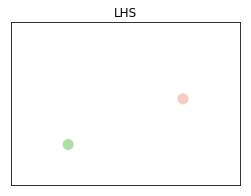

In [10]:
plot_rule(rule)

In [ ]:
instances = h.find_matching('metaModel', pattern)
print("Instances: ", instances)

In [ ]:
h.rewrite('metaModel', rule, instances[0])

## Graph rewritting and propagation down

In [ ]:
pattern = nx.DiGraph()
pattern.add_nodes_from([("w", {"name":{"Paul"}}), "x", "y", "z"])
pattern.add_edges_from([("x", "w"), ("y", "x"), ("y", "z"), ("z","z")])

In [ ]:
rule = Rule.from_transform(pattern)
rule.inject_add_node_attrs("x", {"age":{10}})
rule.inject_add_edge_attrs("x", "w", {"relation":{"brothers"}})
rule.inject_add_node("new_node", {"name":{"Will"}})
rule.inject_add_edge("new_node", "y")
merged_node = rule.inject_merge_nodes(["w", "z"])

In [ ]:
rhs_typing = {
    'metaModel': {'new_node':'a', merged_node: 'a'}
}

In [ ]:
plot_rule(rule)

In [ ]:
instances = h.find_matching('actionGraph', pattern)
print("Instances: ", instances)

In [ ]:
h.rewrite('actionGraph', rule, instances[0], rhs_typing=rhs_typing)

## Removing a graph from the hierarchy

We can also remove a graph from the hierarchy. All its nodes and connections (edges and typing edges) are removed.